# Notebook for Testing Models and Hyperparameter Tunning

This notebook was used as a second step for testing al models


### Ideas for discovering churn pattern 
- Duration  of Subscription
- Network size (intra-net call discounts): we can approximate this with the proportion of calls/messages that are "onnet" and "offnet" and we can also approximate the size of the overall network

- Quality of Service: maybe this is captured by consumer complaints? I am not certain whether they mean complaints from the consumer or to the consumer about not paying.


### Discriminative Variables
- has DataPlan
- Personal o Bussiness
- FIN_STATE

## Asumptions
- Churn is explanied for any reason of termination(Decision of client, Decision of the Telco)
- The test is going to be performend only on December 2013. Not taking into account external variables (MacroEconomics)
- The complaint data for one week and for two weeks seems to be faulty. When comparing the number of complaints for 1 week, 2 weeks, and 1 month, the aggregates do not muchin around 200 cases (where there are more complaints in the last two weeks than during the last month) and around 100 cases (where there are more complaints in the last week than in two weeks). Hence, we will focus on one month, three month, and six month data for the complaints. -(Seppe) could be due to difference on frequency on updating the data.  
- We need to decide on an approach for the complaints, one option is dropping the columnms with one week and two week complaints. Another one is dropping the observations where there is a problem with the aggregated numbers of complaints.

- Given that the financial state variable is almost perfectly correlated with the churn variable (excelpt for 69 observations in the whole dataset), we will exclude it initially. We would have to decide on how to input the missing values and it does not seem informative.
- We will initially drop customer life value given that it has outliers and it is not clear how it was computed
- 0 for clients that does not has data plan
- COUNT_ONNET_CALLS_1WEEK: Includes incoming and outgoing calls

In [35]:
#Imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from lofo import LOFOImportance, plot_importance
from scipy import stats
from boruta import BorutaPy
from sklearn.decomposition import PCA
from imblearn.under_sampling import ClusterCentroids
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

### Functions used for identified task
Section used for:
- Load Dataset
- Feature Engineering
- Feature Imputation
- Feature Selection
- Oversampling using SMOTE
- Data Partitioning
- Feature Trainsformation
- Testing Models

In [59]:
#This function loads the dataset for training. Returns a new Pandas Dataframe
def loadDataset():
    #Dataset Loading
    data = pd.read_csv('telco_train.csv', parse_dates=['START_DATE'])
    original=data.copy()
    print(" ** Number of Rows: "+str(data.shape[0])+" Number of Features: "+str(data.shape[1]-1))
    print("\nProportion of Churn")
    label_balance = data["CHURN"].value_counts()
    print('Normal: {:8d} records {:8.3f} %'.format(label_balance[0], 100*label_balance[0]/data.shape[0]))
    print('Churn:  {:8d} records {:8.3f} %'.format(label_balance[1], 100*label_balance[1]/data.shape[0]))
    return data

#This function loads the testing dataset. Returns a new Pandas Dataframe
def loadTestSet():
    #Dataset Loading
    data = pd.read_csv('telco_test.csv', parse_dates=['START_DATE'])
    id_=data["ID"]
    data.drop(["ID"], axis=1,inplace=True)
    original=data.copy()
    print(" ** Number of Rows: "+str(data.shape[0])+" Number of Features: "+str(data.shape[1]-1))    
    return data,id_

#This function creates a new features to test in the models developed in next steps
def createNewFeatures(data):
    #Create new Features Standard for the Whole Dataset
    #Represent the number of days that the client have been using services from the company.
    data["PLAN_DURATION_DAYS"]=(pd.Timestamp('2013-10-31 00:00:00.000000')-data["START_DATE"]).dt.days
    #Represent year in which the  client started using services from the company.
    data["YEAR_SUSCRIPTION"]=data["START_DATE"].dt.year
    #Boolean has/has not a data plan
    data["HAS_DATA_PLAN"]=(~data["AVG_DATA_3MONTH"].isnull()).astype(int)
    
    #Create Features for the traning and the test set separated
    #data.loc[:,"CALL_NET_SIZE_WKD"]=(data["MINUTES_OUT_ONNET_WKD_1MONTH"]/(data["MINUTES_OUT_ONNET_WKD_1MONTH"]+data["MINUTES_OUT_OFFNET_WKD_1MONTH"]))
    #data.loc[:,"SMS_NET_SIZE_1MONTH"]=(data["COUNT_SMS_OUT_ONNET_1MONTH"]/(data["COUNT_SMS_OUT_ONNET_1MONTH"]+data["COUNT_SMS_OUT_OFFNET_1MONTH"]))
    #data["CALL_NET_SIZE_WKD"].fillna(0, inplace=True)
    #data["SMS_NET_SIZE_1MONTH"].fillna(0, inplace=True)
    data["DAYS_PAYMENT_DELAYS_CURRENT"]=data["DAYS_PAYMENT_DELAYS_CURRENT"]*-1
    
    #data["feacure1"]=data["COUNT_ONNET_CALLS_1WEEK"]/data['COUNT_OFFNET_CALLS_1WEEK']        
    #data["MONTH_SUSCRIPTION"]=data["START_DATE"].dt.month
    #data["SLOPE_COMPLAINTS_1"]=data["COMPLAINT_1MONTH"]-(data["COMPLAINT_3MONTHS"]-data["COMPLAINT_1MONTH"])
    #data["SLOPE_COMPLAINTS_2"]=data["COMPLAINT_1MONTH"]-(data["COMPLAINT_6MONTHS"]-data["COMPLAINT_1MONTH"])/5

#Drop Features not considered for the model. Why this choices were made? Look at the first block
def dataImputation(data):    
    ## Null values of Data Conecctions to Zero
    #data=data.replace([np.inf, -np.inf], np.nan)    
    #data["AVG_DATA_3MONTH"].fillna(0, inplace=True)
    #data["COUNT_CONNECTIONS_3MONTH"].fillna(0, inplace=True)
    #data["AVG_DATA_1MONTH"].fillna(0, inplace=True)
    #data.drop(columns=["AVG_DATA_3MONTH"], inplace=True)
    #data.drop(columns=["COUNT_CONNECTIONS_3MONTH"], inplace=True)
    #data.drop(columns=["AVG_DATA_1MONTH"], inplace=True)
    #data.dropna(inplace=True)          
    #data.drop(columns=["PREPAID"],  inplace=True)
    #data.drop(columns=["HAS_DATA_PLAN"],  inplace=True)
    
    #Drop FIN_STATE (?)
    #data.drop(columns=["FIN_STATE"],  inplace=True)
    data["FIN_STATE"].fillna(-1, inplace=True)
    #Drop COMPLAINT_TWO_WEEK
    data.drop(columns=["COMPLAINT_2WEEKS"],  inplace=True)
    data.drop(columns=["COMPLAINT_1WEEK"],  inplace=True)   
    #Drop START_DATE
    data.drop(columns=['START_DATE'],  inplace=True)
    return data


# drop identifiers found during data exploration phase
def outliers(data):
    #Drop Individual Outliers
    #Outlier: max value in AVG_DATA_3MONTH 
    data.drop( [  191,  722,  988, 1252, 1299, 1378, 1405, 1462, 1569, 2124, 2343,
            2559, 3102, 3361, 3767, 4230, 4308, 4556, 4812], inplace=True)

## Generate Features using PCA transformation using 2 principal components
def appendPCA(data):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data.drop(columns=["CHURN"]))
    print(pca.explained_variance_ratio_)  
    diccionario={}
    for i, a in enumerate(pca.components_):
        diccionario["Variability PC "+str(i+1)]=a
    variability=pd.DataFrame(diccionario, index=data.drop(columns=["CHURN"]).columns).sort_values(ascending=False, by="Variability PC 1")
    data['pca-one'] = pca_result[:,0]
    data['pca-two'] = pca_result[:,1] 
    #data['pca-three'] = pca_result[:,2]
    return variability

## Generate training and test Dataset
def dataPartitioning(data):
    #Partitioning the data
    X=data.drop(["CHURN"], axis=1)
    y=data["CHURN"]
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)    
    #Finally drop Index column, before feeding ML Models
    X_train=X_train.drop(["ID"], axis=1)
    X_test=X_test.drop(["ID"], axis=1)
    return X_train,X_test,y_train,y_test,X_train.columns


#Data imputation which could not be done in previous steps
def dataImputation2(X_train,X_test):
    X_train["AVG_DATA_3MONTH"].fillna(0, inplace=True)
    X_train["COUNT_CONNECTIONS_3MONTH"].fillna(0, inplace=True)
    X_train["AVG_DATA_1MONTH"].fillna(0, inplace=True)

    X_test["AVG_DATA_3MONTH"].fillna(0, inplace=True)
    X_test["COUNT_CONNECTIONS_3MONTH"].fillna(0, inplace=True)
    X_test["AVG_DATA_1MONTH"].fillna(0, inplace=True)


#Data imputation which could not be done in previous steps for the testSet
def dataImputation2Test(data):
    data["AVG_DATA_3MONTH"].fillna(0, inplace=True)
    data["COUNT_CONNECTIONS_3MONTH"].fillna(0, inplace=True)
    data["AVG_DATA_1MONTH"].fillna(0, inplace=True)

#Function used for drop/retain features that were found meaningfull using Boruta Feature Selection
def featureBoruta(X_train,X_test,features):
    featureBoruta=[ True,True, False,  True,  True,  True, False,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True]
    X_train_new=[]
    X_test_new=[]
    new_feature=[]
    for i,v in enumerate(featureBoruta):
        if(v):
            X_train_new.append(X_train[:,i]) 
            X_test_new.append(X_test[:,i])
            new_feature.append(features[i])
    X_train_new=np.array(X_train_new).transpose()
    X_test_new=np.array(X_test_new).transpose()
    new_feature=np.array(new_feature).transpose()
    return X_train_new,X_test_new,new_feature

#Function used for drop/retain features that were found meaningfull using Boruta Feature Selection for the Test Set
def featureBorutaTest(data,features):
    featureBoruta=[ True,True, False,  True,  True,  True, False,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True]
    data_new=[]
    new_feature=[]
    for i,v in enumerate(featureBoruta):
        if(v):
            data_new.append(data[:,i]) 
            new_feature.append(features[i])
    data_new=np.array(data_new).transpose()    
    new_feature=np.array(new_feature).transpose()
    return data_new,new_feature


#Function used for append new PCA features to the training dataset
pca=None    
components=2
def appendPCA2(X_train,X_test,features):
    
    pca = PCA(n_components=components)
    pca_result = pca.fit_transform(X_train)
    print(pca.explained_variance_ratio_)  
    diccionario={}
    for i, a in enumerate(pca.components_):
        diccionario["Variability PC "+str(i+1)]=a
    variability=pd.DataFrame(diccionario, index=features).sort_values(ascending=False, by="Variability PC 1")
    testPCA=pca.transform(X_test)
    X_train=np.append(X_train, pca_result,axis=1)
    X_test=np.append(X_test, testPCA,axis=1)
    newF=list(features)
    for i in range(components):
        #print(type(X_train))
        #print(type(pca_result[:,i]))
        #print(testPCA[:,i].shape)        
        newF.append("pca"+str(i))
    #data['pca-two'] = pca_result[:,1] 
    #data['pca-three'] = pca_result[:,2]
    newF=pd.Series(newF)
    #print(len(features)
    return variability,X_train,X_test,newF,pca

#Function used for append new PCA features to the test dataset
def appendPCA2Test(data,features):   
    testPCA=pca.transform(data)
    data=np.append(data, testPCA,axis=1)
    newF=list(features)
    for i in range(components):
        #print(type(X_train))
        #print(type(pca_result[:,i]))
        #print(testPCA[:,i].shape)        
        newF.append("pca"+str(i))
    #data['pca-two'] = pca_result[:,1] 
    #data['pca-three'] = pca_result[:,2]
    newF=pd.Series(newF)
    #print(len(features)
    return data,newF

## Oversampling using SMOTE strategy    
def oversamplerSmote(X_train, y_train):
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, y_train


#Function used for oversampling during the training phase (deprecated)
def oversampler(X_train, y_train):    
    ros = RandomOverSampler(random_state=0)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    
#Function used for oversampling during the training phase (deprecated)
def underSampling(X_train, y_train):
    cc = ClusterCentroids(random_state=0)
    X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

## Function used Feature Reescaling for training Data Set
transformer=None
def featureRescaler(X_train,X_test):
    transformer = RobustScaler().fit(X_train)
    X_train=transformer.transform(X_train)
    X_test=transformer.transform(X_test)
    return X_train, X_test,transformer

## Function used Feature Reescaling for Test DataSet
def featureRescalerTest(data):    
    data=transformer.transform(data)   
    return data

## Function to test any model using Accuracy and AUC metrics
def evaluate_model(model, X_test, y_test):    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("Accuracy on TEST set: {:.3f}".format(accuracy))
    print("AUC BASE on TEST set: {:.3f}".format(roc_auc))
    return accuracy, roc_auc

#Train and Test using Linear Regression model
def linearRegression(X_train, y_train,X_test, y_test):
    print("Model: Linear Regression =======")
    reg = LinearRegression().fit(X_train, y_train)
    reg.score(X_test, y_test)    
    evaluate_model(reg, X_test, y_test)
    return reg

#Train and Test using Logistic Regression model
def logisticRegression(X_train, y_train,X_test, y_test):
    print("Model: Logistic Regression =======")
    clf = LogisticRegression(random_state=0, solver='lbfgs')
    clf.fit(X_train, y_train)
    evaluate_model(clf, X_test, y_test)
    return clf

#Train and Test using Random Forest model
def randomForest(X_train, y_train,X_test, y_test):
    print("Model: Random Forest =======")
    clf = RandomForestClassifier(n_estimators=700, max_leaf_nodes=None, n_jobs=-1, random_state = 42)
    clf.fit(X_train, y_train)
    evaluate_model(clf, X_test, y_test)
    return clf


#Train and Test using XGBoost model
def xgboost(X_train, y_train,X_test, y_test):
    print("Model: XGBoost =======")
    alg = XGBClassifier(learning_rate=0.1, n_estimators=500, max_depth=5,
                            min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                            objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=10,early_stopping_rounds=10)
    alg.set_params(n_estimators=cvresult.shape[0])    
    alg.fit(X_train, y_train, eval_metric='auc')
    evaluate_model(alg, X_test, y_test)
    return alg

#Train and Test using Gradient Boosting Regression model
def gradientBoosting(X_train, y_train,X_test, y_test):
    print("Model: Gradient Boostig =======")
    clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1,max_depth=10, random_state=0)
    clf.fit(X_train, y_train)
    evaluate_model(clf, X_test, y_test)
    return clf


def neuralNetwork(X_train, y_train,X_test, y_test):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(20, 2), random_state=1)
    print("Model: Neural Network =======")
    clf.fit(X_train, y_train)
    evaluate_model(clf, X_test, y_test)
    return clf

In [68]:
#Load Original Dataset
data=loadDataset()
finState=data["FIN_STATE"]
createNewFeatures(data)
data=dataImputation(data)
data2=data.copy()
outliers(data)

X_train,X_test,y_train,y_test,features=dataPartitioning(data)
print(pd.Series(y_train).value_counts())
dataImputation2(X_train,X_test)
X_train, X_test,transformer=featureRescaler(X_train,X_test)
variability,X_train,X_test,features,pca=appendPCA2(X_train,X_test,features)
X_train, y_train=oversamplerSmote(X_train, y_train)
X_train,X_test,features=featureBoruta(X_train,X_test,features)
#variability
print(pd.Series(y_train).value_counts())

 ** Number of Rows: 5000 Number of Features: 37

Proportion of Churn
Normal:     3554 records   71.080 %
Churn:      1446 records   28.920 %
0    2835
1    1149
Name: CHURN, dtype: int64
[9.99999935e-01 5.47515769e-08]
1    2835
0    2835
dtype: int64


In [62]:
features

array(['PREPAID', 'FIN_STATE', 'COUNT_PAYMENT_DELAYS_1YEAR',
       'DAYS_PAYMENT_DELAYS_CURRENT', 'DAYS_PAYMENT_DELAYS_1YEAR',
       'COMPLAINT_3MONTHS', 'COUNT_OFFNET_CALLS_1WEEK',
       'COUNT_ONNET_CALLS_1WEEK', 'AVG_DATA_3MONTH',
       'COUNT_CONNECTIONS_3MONTH', 'AVG_DATA_1MONTH',
       'COUNT_SMS_INC_ONNET_6MONTH', 'COUNT_SMS_OUT_OFFNET_6MONTH',
       'COUNT_SMS_INC_OFFNET_1MONTH', 'COUNT_SMS_INC_OFFNET_WKD_1MONTH',
       'COUNT_SMS_INC_ONNET_1MONTH', 'COUNT_SMS_OUT_OFFNET_WKD_1MONTH',
       'COUNT_SMS_OUT_ONNET_1MONTH', 'AVG_MINUTES_INC_OFFNET_1MONTH',
       'AVG_MINUTES_INC_ONNET_1MONTH', 'MINUTES_INC_OFFNET_WKD_1MONTH',
       'MINUTES_INC_ONNET_WKD_1MONTH', 'AVG_MINUTES_OUT_OFFNET_1MONTH',
       'AVG_MINUTES_OUT_ONNET_1MONTH', 'MINUTES_OUT_OFFNET_WKD_1MONTH',
       'MINUTES_OUT_ONNET_WKD_1MONTH', 'PLAN_DURATION_DAYS',
       'YEAR_SUSCRIPTION', 'HAS_DATA_PLAN', 'pca1'], dtype='<U31')

## Model Testing using different models

### Logistic Regression

In [63]:
clf=logisticRegression(X_train, y_train,X_test, y_test)

Model: Logistic Regression =======


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy on TEST set: 0.986
AUC BASE on TEST set: 0.978


### Random Forest

In [64]:
clf=randomForest(X_train, y_train,X_test, y_test)

Model: Random Forest =======
Accuracy on TEST set: 0.995
AUC BASE on TEST set: 0.991


### Gradient Boosting

In [65]:
model2=gradientBoosting(X_train, y_train,X_test, y_test)

Model: Gradient Boostig =======
Accuracy on TEST set: 0.992
AUC BASE on TEST set: 0.990


### XGboost Model

In [66]:
model=xgboost(X_train, y_train,X_test, y_test)

Model: XGBoost =======
Accuracy on TEST set: 0.994
AUC BASE on TEST set: 0.991


### Neural Network

In [67]:
model=neuralNetwork(X_train, y_train,X_test, y_test)

Model: Neural Network =======
Accuracy on TEST set: 0.989
AUC BASE on TEST set: 0.985


### Testing of Ensemble Models and HyperParameters Tunning

- This model uses 1 Random Forest Model, 1 GBoost model, 1 Logistic Regression Model 

In [56]:
eclf = VotingClassifier(estimators=[ 
    ('gboost',GradientBoostingClassifier( random_state=0)),
    ('lr', LogisticRegression(random_state=0,solver='lbfgs')), #
    ('rf', RandomForestClassifier(  n_jobs=-1, random_state = 42))
    ], voting='soft')

# dual=[True,False]
# max_iter=[100,110,120,130,140]
# C = [1.0,1.5,2.0,2.5]
#learning_rate=0.1
#max_depth
#max_features
#bootstrap = [True, False] max_features
#Use the key for the classifier followed by __ and the attribute
params = {#'lr__C': [0.7,1.0,2.0],
          'gboost__learning_rate': [0.1,0.2],'gboost__n_estimators': [500,700],'gboost__max_depth': [5,15,None],'gboost__max_features': [12,20,None],
         'rf__bootstrap': [True],'rf__max_depth': [5,10,None],'rf__max_features': ["auto","sqrt"],'rf__n_estimators': [500,700], 
         }

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=10,scoring='roc_auc',verbose=10,n_jobs=-1)

grid.fit(X_train, y_train)

print (grid.best_params_)
evaluate_model(eclf, X_test, y_test)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10

{'gboost__learning_rate': 0.2, 'gboost__max_depth': 5, 'gboost__max_features': None, 'gboost__n_estimators': 500, 'rf__bootstrap': True, 'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__n_estimators': 500}


NotFittedError: This VotingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [57]:
evaluate_model(grid, X_test, y_test)

Accuracy on TEST set: 0.902
AUC BASE on TEST set: 0.872


(0.9017051153460381, 0.8721277033380348)

## Hyperparameter Tunning for XGBoost Model
-Use first RandomizedSearchCV to reduce search space. Then RandoGridSearch

In [ ]:
# We perform K-Fold CV with combination of parameters randomly sampled from the grid defined above
# n_iter * cv fits will be calculated ==> can take long !
# Create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using K fold cross validation, 
# search across n_iter different combinations, and use all available cores
# using roc_auc as metrics to optimize
rf_random = RandomizedSearchCV(scoring='roc_auc',estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
# show best params
print('best param found:')
print(rf_random.best_params_)
print('corresponding to best ROC AUC score on VALIDATION set (K fold CV):')
print(rf_random.best_score_)

In [89]:
from sklearn.model_selection import StratifiedKFold
xgb_model = xgb.XGBClassifier()


parameters = {#'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.1], #so called `eta` value
              'max_depth': [4,5],
              'min_child_weight': [3,5],
              'silent': [1],
              'subsample': [0.8],
              'gamma': [0.2],
              'colsample_bytree': [0.6],
              'n_estimators': [400,700], #number of trees, change it to 1000 for better results
              'seed': [27],
              'scale_pos_weight':[1]}

skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1001)


clf = GridSearchCV(xgb_model, parameters, n_jobs=-1, 
                   cv=skf.split(X_train,y_train), 
                   scoring='roc_auc',
                   verbose=10, refit=True)


clf.fit(X_train, y_train)
evaluate_model(clf, X_test, y_test)

# alg = XGBClassifier(learning_rate=0.1, n_estimators=400, max_depth=5,
#                             min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
#                             objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
#     xgb_param = alg.get_xgb_params()
#     xgtrain = xgb.DMatrix(X_train, label=y_train)
#     cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=10,early_stopping_rounds=10)
#     alg.set_params(n_estimators=cvresult.shape[0])    
#     alg.fit(X_train, y_train, eval_metric='auc')
#     evaluate_model(alg, X_test, y_test)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:  2.3min remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.5min finished


Accuracy on TEST set: 0.891
AUC BASE on TEST set: 0.857


(0.8906720160481444, 0.8571540510891709)

In [72]:
print (clf.best_params_)

{'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 700, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'seed': 27, 'silent': 1, 'subsample': 0.8}


## Boruta Feature Selection

Use this strategy to drop features not meaninful for predictions

In [127]:
feat_selector = BorutaPy(alg, n_estimators='auto', verbose=2, random_state=17)

# find all relevant features - 5 features should be selected
feat_selector.fit(X_train, y_train)

# check selected features - first 5 features are selected
feat_selector.support_



Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	24
Tentative: 	13
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	24
Tentative: 	11
Rejected: 	2


c:\program files\python36\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	24
Tentative: 	11
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	24
Tentative: 	11
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	27
Tentative: 	8
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	27
Tentative: 	8
Rejected: 	2
Iteration: 	14 / 100
Confirmed: 	27
Tentative: 	7
Rejected: 	3
Iteration: 	15 / 100
Confirmed: 	27
Tentative: 	7
Rejected: 	3
Iteration: 	16 / 100
Confirmed: 	27
Tentative: 	7
Rejected: 	3
Iteration: 	17 / 100
Confirmed: 	27
Tentative: 	7
Rejected: 	3
Iteration: 	18 / 100
Confirmed: 	27
Tentative: 	7
Rejected: 	3
Iteration: 	19 / 100
Confirmed: 	27
Tentative: 	7
Rejected: 	3
Iteration: 	20 / 100
Confirmed: 	27
Tentative: 	7
Rejected: 	3
Iteration: 	21 / 100
Confirmed: 	27
Tentative: 	7
Rejected: 	3
Iteration: 	22 / 100
Confirmed: 	28
Tentative: 	6
Rejected: 	3
Iteration: 	23 / 100
Confirmed: 	28
Tentative: 	6
Rejected: 	3
Iteration: 	24 / 100
Confirmed: 	28
Tentative: 	6
Rejected: 	3
Iteration: 	25 / 100
Confirmed: 	28
Tentative: 	6
Rej

array([ True, False,  True,  True,  True, False,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True])

In [130]:
# check ranking of features
feat_selector.ranking_

array([1, 4, 1, 1, 1, 5, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 6, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1])

### Testing of  Model XGBoost and  Random Forest model using Boruta Feature Selection 

In [131]:
# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X_train)
X_filteredTest = feat_selector.transform(X_test)

clf2=randomForest(X_filtered, y_train,X_filteredTest, y_test)
model2=xgboost(X_filtered, y_train,X_filteredTest, y_test)

#X_filtered.shape
#rf2 = RandomForestClassifier(n_jobs=-1)
#rf2.fit(X_filtered,y_train)


Model: Random Forest =======
Accuracy on TEST set: 0.899
AUC BASE on TEST set: 0.865
Model: XGBoost =======
Accuracy on TEST set: 0.900
AUC BASE on TEST set: 0.874


### Plot some correlations to decide which features we can drop 

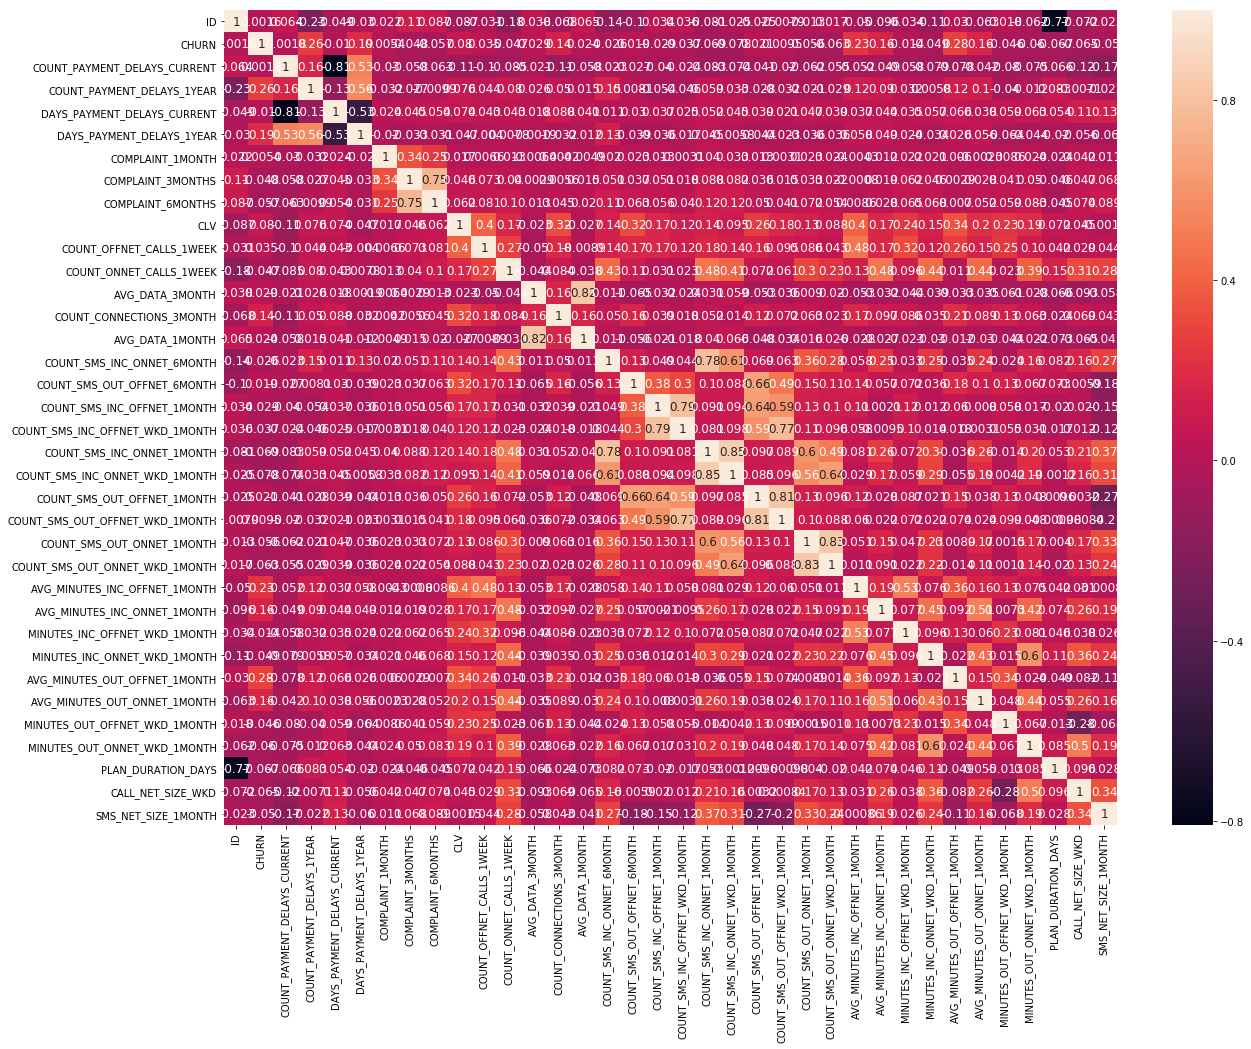

Top Absolute Correlations of features
COUNT_SMS_INC_ONNET_1MONTH       COUNT_SMS_INC_ONNET_WKD_1MONTH     0.849728
COUNT_SMS_OUT_ONNET_1MONTH       COUNT_SMS_OUT_ONNET_WKD_1MONTH     0.826837
AVG_DATA_3MONTH                  AVG_DATA_1MONTH                    0.816415
COUNT_SMS_OUT_OFFNET_1MONTH      COUNT_SMS_OUT_OFFNET_WKD_1MONTH    0.809761
COUNT_PAYMENT_DELAYS_CURRENT     DAYS_PAYMENT_DELAYS_CURRENT        0.809540
COUNT_SMS_INC_OFFNET_1MONTH      COUNT_SMS_INC_OFFNET_WKD_1MONTH    0.793369
COUNT_SMS_INC_ONNET_6MONTH       COUNT_SMS_INC_ONNET_1MONTH         0.783466
COUNT_SMS_INC_OFFNET_WKD_1MONTH  COUNT_SMS_OUT_OFFNET_WKD_1MONTH    0.771260
COMPLAINT_3MONTHS                COMPLAINT_6MONTHS                  0.746274
COUNT_SMS_OUT_OFFNET_6MONTH      COUNT_SMS_OUT_OFFNET_1MONTH        0.655997
COUNT_SMS_INC_OFFNET_1MONTH      COUNT_SMS_OUT_OFFNET_1MONTH        0.642481
COUNT_SMS_INC_ONNET_WKD_1MONTH   COUNT_SMS_OUT_ONNET_WKD_1MONTH     0.640954
COUNT_SMS_INC_ONNET_6MONTH       COUNT

In [342]:
plotCorrelations(data)

In [30]:
def plotCorrelations(data):
    corr = data.corr()
    sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
    heat_map=plt.gcf()
    heat_map.set_size_inches(20,15)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

    def get_redundant_pairs(df):
        '''Get diagonal and lower triangular pairs of correlation matrix'''
        pairs_to_drop = set()
        cols = df.columns
        for i in range(0, df.shape[1]):
            for j in range(0, i+1):
                pairs_to_drop.add((cols[i], cols[j]))
        return pairs_to_drop

    def get_top_abs_correlations(df, n=5):
        au_corr = df.corr().abs().unstack()
        labels_to_drop = get_redundant_pairs(df)
        au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)    
        return au_corr[0:n]

    ##Usage
    print("Top Absolute Correlations of features")
    X =data.drop(["ID"], axis=1)
    print(get_top_abs_correlations(X, 50))

def featureImportance(x,clf):
    train_df = x

    # extract a sample of the data
    sample_df = train_df.sample(frac=0.01, random_state=0)
    #sample_df.sort_values("AvSigVersion", inplace=True)

    # define the validation scheme
    cv = KFold(n_splits=4, shuffle=False, random_state=0)

    # define the binary target and the features
    target = "CHURN"
    features = [col for col in train_df.columns if col != target]

    # define the validation scheme and scorer. The default model is LightGBM
    lofo_imp = LOFOImportance(sample_df, features, target, cv=cv, scoring="roc_auc", model=clf)

    # get the mean and standard deviation of the importances in pandas format
    importance_df = lofo_imp.get_importance()

    # plot the means and standard deviations of the importances
    plot_importance(importance_df, figsize=(12, 20))

    print(importance_df)